# Part 1: EDA

Below is our exploratory data analysis of users of the hypothetical InterConnect internet and phone service. The first two dataframes contain user contract and personal information, while the latter two dataframes contain internet and phone service option data. Some of these users have a date on which they discontinued service (churned). All other users are active as of the pulling of the data, on February 1, 2020.

The business has expressed an interest in identifying users who are about to churn. InterConnect could then offer incentives and discounts. To accomplish this task, we can build a machine learning model that can profile users and identify likely churn candidates.

Before we build a model, we should clean the data contained in the source CSVs, create useful features to feed into the model, and explore the data to understand the distribution of -- and relationships between -- features. This notebook contains only that exploratory analysis, and some target questions to consider thereafter. We will conclude with a full plan for building our ideal model.

## Initializing

In [1]:
# Base libraries
import pandas as pd
import numpy as np

# Machine Learning libraries
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# Graphing libraries
from matplotlib import pyplot as plt
import seaborn as sns

# I/O libraries
import pickle
import json

In [2]:
# Read the CSVs into dataframes
df_contracts_raw = pd.read_csv('./datasets/final_provider/contract.csv')
df_personal_raw = pd.read_csv('./datasets/final_provider/personal.csv')
df_internet_raw = pd.read_csv('./datasets/final_provider/internet.csv')
df_phone_raw = pd.read_csv('./datasets/final_provider/phone.csv')

## Pre-processing

This is our opportunity to check for missing values and duplicates, and then to generate new values and features before entering the domain of statistics.

### Contracts

This is the dataframe for user information, which also contains the target for our task: whether a user has churned is captured in the 'EndDate' column.

In [3]:
# Make a copy to preserve original data
df_contracts = df_contracts_raw.copy()

# Quick view
df_contracts.info()
df_contracts.sample(10, random_state=12345)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


customerID   BeginDate              EndDate            Type  \
1128  0098-BOWSO  2017-11-01                   No  Month-to-month   
2875  9992-RRAMN  2018-02-01  2019-12-01 00:00:00  Month-to-month   
1783  8380-PEFPE  2019-09-01  2019-10-01 00:00:00  Month-to-month   
3804  9773-PEQBZ  2019-04-01                   No  Month-to-month   
6087  8319-QBEHW  2017-12-01                   No        One year   
2071  3392-EHMNK  2014-07-01                   No        Two year   
2395  6486-LHTMA  2017-07-01                   No        One year   
4660  0883-EIBTI  2019-10-01  2019-12-01 00:00:00  Month-to-month   
372   6122-EFVKN  2018-02-01                   No        Two year   
1143  2446-ZKVAF  2018-08-01                   No  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
1128              Yes           Electronic check           19.40        529.8  
2875              Yes           Electronic check           85.10       1873.7  
1783              Yes           Electronic check           71.65        71.65  
3804               No           Electronic check           79.85       797.25  
6087              Yes  Bank transfer (automatic)           39.95      1023.75  
2071               No    Credit card (automatic)           94.10       6302.8  
2395              Yes           Electronic check           90.70       2835.5  
4660               No               Mailed check           19.50        31.55  
372                No               Mailed check           35.75        830.8  
1143               No    Credit card (automatic)           56.80      1074.65

Since 'TotalCharges' appears as an object type and not a float64 as the 'MonthlyCharges' feature is, we can assume there are values tripping up its correct processing. We should investigate. Additionally, 'PaperlessBilling' is more useful as a bool. 

In [4]:
# Make 'PaperlessBilling' a bool
df_contracts['PaperlessBilling'] = df_contracts['PaperlessBilling'] == 'Yes'

In [5]:
# Convert TotalCharges to a float
df_contracts['TotalCharges'] = pd.to_numeric(df_contracts['TotalCharges'], errors='coerce')

# Check our work
df_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   bool   
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: bool(1), float64(2), object(5)
memory usage: 392.2+ KB


In [6]:
# Investigate the 11 null values for TotalCharges
display(df_contracts[df_contracts['TotalCharges'].isna()])

customerID   BeginDate EndDate      Type  PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              True   
753   3115-CZMZD  2020-02-01      No  Two year             False   
936   5709-LVOEQ  2020-02-01      No  Two year             False   
1082  4367-NUYAO  2020-02-01      No  Two year             False   
1340  1371-DWPAZ  2020-02-01      No  Two year             False   
3331  7644-OMVMY  2020-02-01      No  Two year             False   
3826  3213-VVOLG  2020-02-01      No  Two year             False   
4380  2520-SGTTA  2020-02-01      No  Two year             False   
5218  2923-ARZLG  2020-02-01      No  One year              True   
6670  4075-WKNIU  2020-02-01      No  Two year             False   
6754  2775-SEFEE  2020-02-01      No  Two year              True   

                  PaymentMethod  MonthlyCharges  TotalCharges  
488   Bank transfer (automatic)           52.55           NaN  
753                Mailed check           20.25           NaN  
936                Mailed check           80.85           NaN  
1082               Mailed check           25.75           NaN  
1340    Credit card (automatic)           56.05           NaN  
3331               Mailed check           19.85           NaN  
3826               Mailed check           25.35           NaN  
4380               Mailed check           20.00           NaN  
5218               Mailed check           19.70           NaN  
6670               Mailed check           73.35           NaN  
6754  Bank transfer (automatic)           61.90           NaN

These customers joined on 2020-02-01, which is the same day that the data was pulled. This means they have not yet paid a bill as they are fresh customers. We can safely replace the NaN values with 0s since they have, in fact, paid $0.

Then we will check for duplicates and remove extraneous columns.

In [7]:
# Replace NaNs with 0s
df_contracts['TotalCharges'] = df_contracts['TotalCharges'].fillna(0)

In [8]:
# Check for duplicates
display(df_contracts[df_contracts.duplicated()])

Empty DataFrame
Columns: [customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges]
Index: []

There are no duplicate entries or extraneous columns. The 'columnID' is not useful for ML training but is required to align with user info in the other dataframes.

The original data was pulled on Feb 1, 2020, so we can treat 2020-02-01 as the datetime value of the "current" time. Subtracting the datetime value from their contract beginning will give the measure of how long they have been a customer.

We should first create a new column 'Churned' which will become our target column before modifying the 'EndDate' column.

In [9]:
# NEW column 'Churned' (type: bool)
df_contracts['Churned'] = df_contracts['EndDate'] != 'No'

display(df_contracts[['EndDate', 'Churned']].sample(10, random_state=12345))

EndDate  Churned
1128                   No    False
2875  2019-12-01 00:00:00     True
1783  2019-10-01 00:00:00     True
3804                   No    False
6087                   No    False
2071                   No    False
2395                   No    False
4660  2019-12-01 00:00:00     True
372                    No    False
1143                   No    False

In [10]:
# Column 'BeginDate' can garner for us a measure of how long they have been a customer, which is very valuable. 
# First we should replace all 'No' values with the date of pulling the data, which is 2020-02-01
df_contracts['EndDate'] = df_contracts['EndDate'].where(df_contracts['EndDate'] != 'No', '2020-02-01 00:00:00')

We are ready to create new datetime features. Machine learning models cannot process datetime values, so we will use the datetime type for some useful math when creating a few new features.

We will create two new features via datetime math: 'DaysCustomer', which reflects the number of days a user was/is a customer, and 'ChurnSeasonality', which assigns a value from -1 to 1 on whether a user churned in a similar or dissimilar time of year as they signed up. Using a cosine function on the remainder of the division of 'DaysCustomer' by 365.25 (accounting for leap years) yields this function.

The year of past users' churning is irrelevant to training a model in our task of determining whether a current active user will churn. The length of a user being active is now captured in a new feature, so we can afford to drop the 'BeginDate' and 'EndDate' columns.

In [11]:
# Then we can convert both columns to datetime, dropping time values
df_contracts['BeginDate'] = pd.to_datetime(df_contracts['BeginDate'], format='%Y-%m-%d')
df_contracts['EndDate'] = pd.to_datetime(df_contracts['EndDate'], format='%Y-%m-%d', exact=False) #ignore irrelevant time data

# NEW column 'DaysCustomer' (type: float64)
df_contracts['DaysCustomer'] = df_contracts['EndDate'] - df_contracts['BeginDate']
df_contracts['DaysCustomer'] = pd.to_numeric(df_contracts['DaysCustomer'].dt.days)

# NEW column 'ChurnSeasonality' (type: float64)
df_contracts['ChurnSeasonality'] = np.cos(2 * np.pi * (df_contracts['DaysCustomer'] % 365.25) / 365.25) #account for leap year

# DROP columns 'BeginDate' and 'EndDate'
df_contracts = df_contracts.drop(['BeginDate', 'EndDate'], axis=1)

In [12]:
# Final check against the above before moving on
df_contracts.info()
df_contracts.sample(10, random_state=12345)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   bool   
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   Churned           7043 non-null   bool   
 7   DaysCustomer      7043 non-null   int64  
 8   ChurnSeasonality  7043 non-null   float64
dtypes: bool(2), float64(3), int64(1), object(3)
memory usage: 399.0+ KB


customerID            Type  PaperlessBilling              PaymentMethod  \
1128  0098-BOWSO  Month-to-month              True           Electronic check   
2875  9992-RRAMN  Month-to-month              True           Electronic check   
1783  8380-PEFPE  Month-to-month              True           Electronic check   
3804  9773-PEQBZ  Month-to-month             False           Electronic check   
6087  8319-QBEHW        One year              True  Bank transfer (automatic)   
2071  3392-EHMNK        Two year             False    Credit card (automatic)   
2395  6486-LHTMA        One year              True           Electronic check   
4660  0883-EIBTI  Month-to-month             False               Mailed check   
372   6122-EFVKN        Two year             False               Mailed check   
1143  2446-ZKVAF  Month-to-month             False    Credit card (automatic)   

      MonthlyCharges  TotalCharges  Churned  DaysCustomer  ChurnSeasonality  
1128           19.40        529.80    False           822         -0.003225  
2875           85.10       1873.70     True           668          0.475599  
1783           71.65         71.65     True            30          0.869764  
3804           79.85        797.25    False           306          0.524010  
6087           39.95       1023.75    False           792          0.490660  
2071           94.10       6302.80    False          2041         -0.851148  
2395           90.70       2835.50    False           945         -0.853398  
4660           19.50         31.55     True            61          0.498137  
372            35.75        830.80    False           730          0.999963  
1143           56.80       1074.65    False           549         -0.999813

### Personal

This is the dataframe with personal information about users, beyond their plan and payment information above. This can be a helpful dataset to classify user backgrounds.

In [13]:
# Make a copy to preserve original data
df_personal = df_personal_raw.copy()

# Quick view
df_personal.info()
display(df_personal.sample(10, random_state=12345))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


customerID  gender  SeniorCitizen Partner Dependents
1128  0098-BOWSO    Male              0      No         No
2875  9992-RRAMN    Male              0     Yes         No
1783  8380-PEFPE    Male              0      No        Yes
3804  9773-PEQBZ    Male              0      No         No
6087  8319-QBEHW    Male              0      No        Yes
2071  3392-EHMNK  Female              0     Yes        Yes
2395  6486-LHTMA  Female              1     Yes         No
4660  0883-EIBTI  Female              0      No         No
372   6122-EFVKN    Male              0      No        Yes
1143  2446-ZKVAF    Male              0     Yes         No

'SeniorCitizen', 'Partner' and 'Dependents' work best as boolean values for efficiency. We should confirm whether the 'gender' column is also a binary classification in this dataset, and if so, convert that to boolean.

In [14]:
display(df_personal['gender'].value_counts())

gender
Male      3555
Female    3488
Name: count, dtype: int64

In [15]:
# Make all bool
df_personal['gender'] = df_personal['gender'] == 'Female'
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'] == '1'
df_personal['Partner'] = df_personal['Partner'] == 'Yes'
df_personal['Dependents'] = df_personal['Dependents'] == 'Yes'

# Check our work against the above
display(df_personal.sample(10, random_state=12345))

customerID  gender  SeniorCitizen  Partner  Dependents
1128  0098-BOWSO   False          False    False       False
2875  9992-RRAMN   False          False     True       False
1783  8380-PEFPE   False          False    False        True
3804  9773-PEQBZ   False          False    False       False
6087  8319-QBEHW   False          False    False        True
2071  3392-EHMNK    True          False     True        True
2395  6486-LHTMA    True          False     True       False
4660  0883-EIBTI    True          False    False       False
372   6122-EFVKN   False          False    False        True
1143  2446-ZKVAF   False          False     True       False

### Internet

This is the dataframe demonstrating the internet options users take.

In [16]:
# Make a copy to preserve original data
df_internet = df_internet_raw.copy()

# Quick view
df_internet.info()
df_internet.sample(10, random_state=12345)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
4878  7823-JSOAG     Fiber optic             No           No               No   
5002  4450-YOOHP             DSL             No           No              Yes   
4160  2498-XLDZR             DSL            Yes          Yes              Yes   
683   7905-TVXTA             DSL            Yes           No               No   
1930  9802-CAQUT     Fiber optic            Yes          Yes              Yes   
2140  3387-VATUS     Fiber optic             No           No               No   
2311  2845-AFFTX     Fiber optic             No           No              Yes   
3417  0853-NWIFK     Fiber optic            Yes          Yes               No   
1472  0973-KYVNF             DSL            Yes          Yes              Yes   
4716  9253-QXKBE     Fiber optic             No           No               No   

     TechSupport StreamingTV StreamingMovies  
4878          No          No              No  
5002          No         Yes             Yes  
4160         Yes          No             Yes  
683          Yes         Yes              No  
1930          No         Yes             Yes  
2140          No         Yes             Yes  
2311          No         Yes             Yes  
3417          No         Yes             Yes  
1472          No         Yes              No  
4716          No         Yes             Yes

In [17]:
# Check for categories on InternetService
df_internet['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

In [18]:
# Convert all to bool for efficient procesing
df_internet['InternetService'] = df_internet['InternetService'] == 'Fiber optic'
yesno_list = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in yesno_list:
    df_internet[col] = df_internet[col] == 'Yes'

In [19]:
# Check for duplicates
display(df_internet[df_internet.duplicated()])

Empty DataFrame
Columns: [customerID, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies]
Index: []

There are no duplicates and all features have been cleaned.

In [20]:
# Show our work 
display(df_internet.sample(10, random_state=12345))

customerID  InternetService  OnlineSecurity  OnlineBackup  \
4878  7823-JSOAG             True           False         False   
5002  4450-YOOHP            False           False         False   
4160  2498-XLDZR            False            True          True   
683   7905-TVXTA            False            True         False   
1930  9802-CAQUT             True            True          True   
2140  3387-VATUS             True           False         False   
2311  2845-AFFTX             True           False         False   
3417  0853-NWIFK             True            True          True   
1472  0973-KYVNF            False            True          True   
4716  9253-QXKBE             True           False         False   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  
4878             False        False        False            False  
5002              True        False         True             True  
4160              True         True        False             True  
683              False         True         True            False  
1930              True        False         True             True  
2140             False        False         True             True  
2311              True        False         True             True  
3417             False        False         True             True  
1472              True        False         True            False  
4716             False        False         True             True

The first two dataframes have 7,043 rows, but the internet dataframe has 5,517 rows. This is presumably due to some users' lack of utilization of internet services.

### Phone

This is the dataframe demonstrating the phone options users take.

In [21]:
# Make a copy to preserve original data
df_phone = df_phone_raw.copy()

# Quick view
df_phone.info()
df_phone.sample(10, random_state=12345)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


customerID MultipleLines
1649  8966-KZXXA           Yes
1920  7206-PQBBZ            No
2852  4567-AKPIA           Yes
911   7047-YXDMZ            No
6259  7619-PLRLP           Yes
3581  1304-NECVQ           Yes
5992  9248-OJYKK           Yes
3169  2921-XWDJH            No
3903  9134-WYRVP            No
121   3774-VBNXY            No

In [22]:
# Make bool
df_phone['MultipleLines'] = df_phone['MultipleLines'] == 'Yes'

In [23]:
# Check for duplicates
display(df_phone[df_phone.duplicated()])

Empty DataFrame
Columns: [customerID, MultipleLines]
Index: []

There are no duplicates and all features have been cleaned.

In [24]:
# Check our work
display(df_phone.sample(10, random_state=12345))

customerID  MultipleLines
1649  8966-KZXXA           True
1920  7206-PQBBZ          False
2852  4567-AKPIA           True
911   7047-YXDMZ          False
6259  7619-PLRLP           True
3581  1304-NECVQ           True
5992  9248-OJYKK           True
3169  2921-XWDJH          False
3903  9134-WYRVP          False
121   3774-VBNXY          False

As with the internet dataframe, the phone dataframe contains fewer rows (6,361) than the total users (7,043), suggesting not all users utilize phone plans.

### Merge Data to Master Dataframe

Our goal here is to merge all the dataframes without dropping any users. This will require using three outer merges, which fill missing matches with NaNs. Luckily, the df_internet and df_phone dataframes only contain bool columns, so filling the NaN values will be trivial.

In [25]:
# Successive merges onto dataframe
df = df_contracts.merge(df_personal, on='customerID', how='outer')
df = df.merge(df_internet, on='customerID', how='outer')
df = df.merge(df_phone, on='customerID', how='outer')

# Check our work
df.info()
df.sample(20, random_state=12345)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   bool   
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   Churned           7043 non-null   bool   
 7   DaysCustomer      7043 non-null   int64  
 8   ChurnSeasonality  7043 non-null   float64
 9   gender            7043 non-null   bool   
 10  SeniorCitizen     7043 non-null   bool   
 11  Partner           7043 non-null   bool   
 12  Dependents        7043 non-null   bool   
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


customerID            Type  PaperlessBilling              PaymentMethod  \
1128  1657-DYMBM        Two year             False    Credit card (automatic)   
2875  4097-YODCF        One year              True           Electronic check   
1783  2606-RMDHZ  Month-to-month              True    Credit card (automatic)   
3804  5349-IECLD  Month-to-month             False           Electronic check   
6087  8626-PTQGE        Two year              True  Bank transfer (automatic)   
2071  2982-IHMFT  Month-to-month              True               Mailed check   
2395  3423-HHXAO        One year              True               Mailed check   
4660  6578-KRMAW  Month-to-month              True    Credit card (automatic)   
372   0550-DCXLH  Month-to-month             False               Mailed check   
1143  1684-FLBGS  Month-to-month              True    Credit card (automatic)   
294   0432-CAJZV  Month-to-month             False               Mailed check   
4632  6537-OTKMY        One year             False           Electronic check   
3681  5192-EBGOV  Month-to-month              True           Electronic check   
1080  1573-LGXBA        One year              True    Credit card (automatic)   
3065  4389-UEFCZ        Two year              True           Electronic check   
3045  4360-QRAVE  Month-to-month             False           Electronic check   
6662  9479-HYNYL        Two year              True    Credit card (automatic)   
3848  5404-GGUKR  Month-to-month              True           Electronic check   
3684  5196-SGOAK  Month-to-month              True           Electronic check   
1255  1853-UDXBW  Month-to-month              True           Electronic check   

      MonthlyCharges  TotalCharges  Churned  DaysCustomer  ChurnSeasonality  \
1128           19.90       1110.05    False          1614         -0.872929   
2875          103.80       3470.80    False          1036          0.516665   
1783           30.50        208.70     True           184         -0.999720   
3804           94.95        178.10     True            61          0.498137   
6087           60.05       4176.70    False          2102          0.031174   
2071           74.45         74.45     True            31          0.861147   
2395           19.50        272.00    False           427          0.486908   
4660           93.40       2979.30    False           975         -0.485029   
372            73.35        931.55    False           396          0.863325   
1143           69.50       1652.10    False           702          0.882206   
294            90.70        237.65    False            92         -0.011826   
4632           50.75        688.20    False           457         -0.007526   
3681           85.70         85.70     True            30          0.869764   
1080           97.55       5598.00    False          1737          0.035473   
3065          105.50       7544.00    False          2191          0.999963   
3045           36.65       1315.00    False          1126          0.867634   
6662           80.70       5705.05    False          2163          0.882206   
3848           51.35        262.30    False           153         -0.872929   
3684           75.70         75.70     True            31          0.861147   
1255           70.00         70.00     True            31          0.861147   

      gender  ...  Partner  Dependents  InternetService OnlineSecurity  \
1128   False  ...     True       False              NaN            NaN   
2875   False  ...    False        True             True           True   
1783   False  ...    False       False            False          False   
3804   False  ...    False       False             True          False   
6087   False  ...    False       False            False           True   
2071    True  ...    False       False             True          False   
2395    True  ...     True        True              NaN            NaN   
4660   False  ...    False       False             T

We know that all NaN values come originally from the df_internet and df_phone dataframes, which indicate that the user doesn't have any part of that service. It is valuable information that a user doesn't have an entire service category (or, more accurately, it is valuable information that a user has one or two service categories). 

We can create two new features to reflect whether a user is included in the df_internet and df_phone dataframes, respectively. Then we can fill all the NaN values with False, which is a true statement for each customer.

In [26]:
# Two NEW features for whether user has Internet and whether user has Phone service (type: bool)
df['HasInternet'] = ~df[yesno_list].isna().any(axis=1) # yesno_list taken from above: col names from df_internet
df['HasPhone'] = ~df['MultipleLines'].isna()

In [27]:
# Replace all NaN values (meaning the customer doesn't have that service) with False to preserve data type as bool
df = df.fillna(False)

C:\Users\brian\AppData\Local\Temp\ipykernel_19736\2529933191.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


In [28]:
# Check our work
df.info()
df.sample(20, random_state=12345)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   bool   
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   Churned           7043 non-null   bool   
 7   DaysCustomer      7043 non-null   int64  
 8   ChurnSeasonality  7043 non-null   float64
 9   gender            7043 non-null   bool   
 10  SeniorCitizen     7043 non-null   bool   
 11  Partner           7043 non-null   bool   
 12  Dependents        7043 non-null   bool   
 13  InternetService   7043 non-null   bool   
 14  OnlineSecurity    7043 non-null   bool   
 15  OnlineBackup      7043 non-null   bool   
 16  DeviceProtection  7043 non-null   bool   


customerID            Type  PaperlessBilling              PaymentMethod  \
1128  1657-DYMBM        Two year             False    Credit card (automatic)   
2875  4097-YODCF        One year              True           Electronic check   
1783  2606-RMDHZ  Month-to-month              True    Credit card (automatic)   
3804  5349-IECLD  Month-to-month             False           Electronic check   
6087  8626-PTQGE        Two year              True  Bank transfer (automatic)   
2071  2982-IHMFT  Month-to-month              True               Mailed check   
2395  3423-HHXAO        One year              True               Mailed check   
4660  6578-KRMAW  Month-to-month              True    Credit card (automatic)   
372   0550-DCXLH  Month-to-month             False               Mailed check   
1143  1684-FLBGS  Month-to-month              True    Credit card (automatic)   
294   0432-CAJZV  Month-to-month             False               Mailed check   
4632  6537-OTKMY        One year             False           Electronic check   
3681  5192-EBGOV  Month-to-month              True           Electronic check   
1080  1573-LGXBA        One year              True    Credit card (automatic)   
3065  4389-UEFCZ        Two year              True           Electronic check   
3045  4360-QRAVE  Month-to-month             False           Electronic check   
6662  9479-HYNYL        Two year              True    Credit card (automatic)   
3848  5404-GGUKR  Month-to-month              True           Electronic check   
3684  5196-SGOAK  Month-to-month              True           Electronic check   
1255  1853-UDXBW  Month-to-month              True           Electronic check   

      MonthlyCharges  TotalCharges  Churned  DaysCustomer  ChurnSeasonality  \
1128           19.90       1110.05    False          1614         -0.872929   
2875          103.80       3470.80    False          1036          0.516665   
1783           30.50        208.70     True           184         -0.999720   
3804           94.95        178.10     True            61          0.498137   
6087           60.05       4176.70    False          2102          0.031174   
2071           74.45         74.45     True            31          0.861147   
2395           19.50        272.00    False           427          0.486908   
4660           93.40       2979.30    False           975         -0.485029   
372            73.35        931.55    False           396          0.863325   
1143           69.50       1652.10    False           702          0.882206   
294            90.70        237.65    False            92         -0.011826   
4632           50.75        688.20    False           457         -0.007526   
3681           85.70         85.70     True            30          0.869764   
1080           97.55       5598.00    False          1737          0.035473   
3065          105.50       7544.00    False          2191          0.999963   
3045           36.65       1315.00    False          1126          0.867634   
6662           80.70       5705.05    False          2163          0.882206   
3848           51.35        262.30    False           153         -0.872929   
3684           75.70         75.70     True            31          0.861147   
1255           70.00         70.00     True            31          0.861147   

      gender  ...  InternetService  OnlineSecurity  OnlineBackup  \
1128   False  ...            False           False         False   
2875   False  ...             True            True          True   
1783   False  ...            False           False          True   
3804   False  ...             True           False         False   
6087   False  ...            False            True          True   
2071    True  ...             True           False         False   
2395    True  ...            False           False         False   
4660   False  ...             True            True          True   
372    False  ...            Fal

## Exploratory Data Analysis

### Examine Quantitative Feature Distributions

We can first look at the distributions of four numeric features: monthly charges, total charges, churn date against start date seasonality, and the total days users have been customers. We'll look at the same pairplot distribution graphs with three different categories to color the distributions: user contract type, payment type, and our target feature -- whether users have discontinued service (churned).

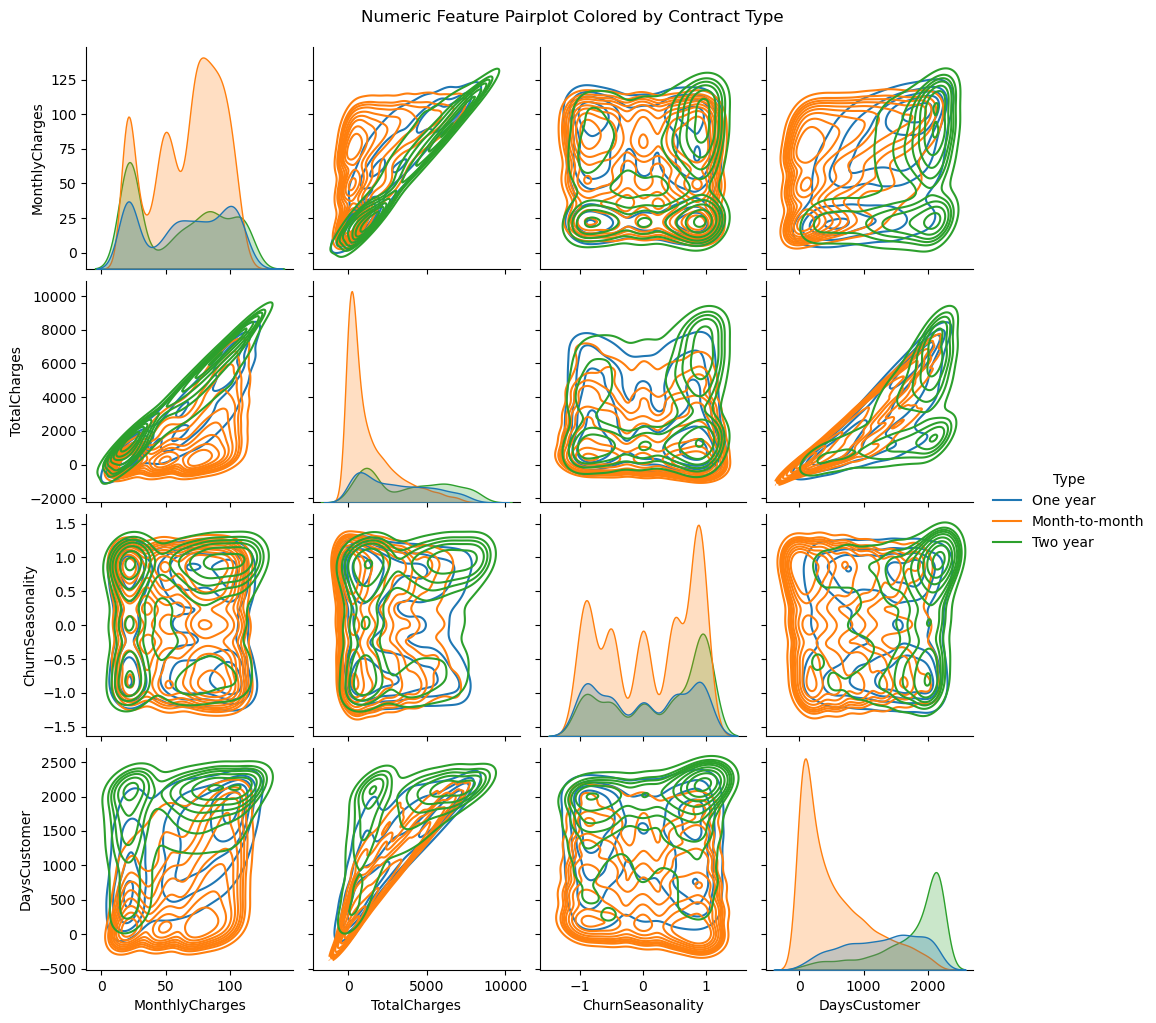

In [29]:
numeric_cols = ['MonthlyCharges', 'TotalCharges', 'ChurnSeasonality', 'DaysCustomer']
pp = sns.pairplot(df[['Type'] + numeric_cols], kind='kde', hue='Type')
pp.fig.suptitle("Numeric Feature Pairplot Colored by Contract Type", y=1.02)
plt.show()

The first item to note is that there are more total month-to-month users. Looking at the final graph (bottom right), among users who are have not been customers for long, they are overwhelmingly month-to-month, indicating most users in 2020 are beginning their service as month-to-month users. The considerable left-skew of the two-year contract users indicates that newer users are not favoring two-year contracts.

Month-to-month users, however, are rather evenly distibuted in the 'MonthlyCharges' features. In fact, none of the contract types are especially left- or right-distributted despite all having local peaks at $25.

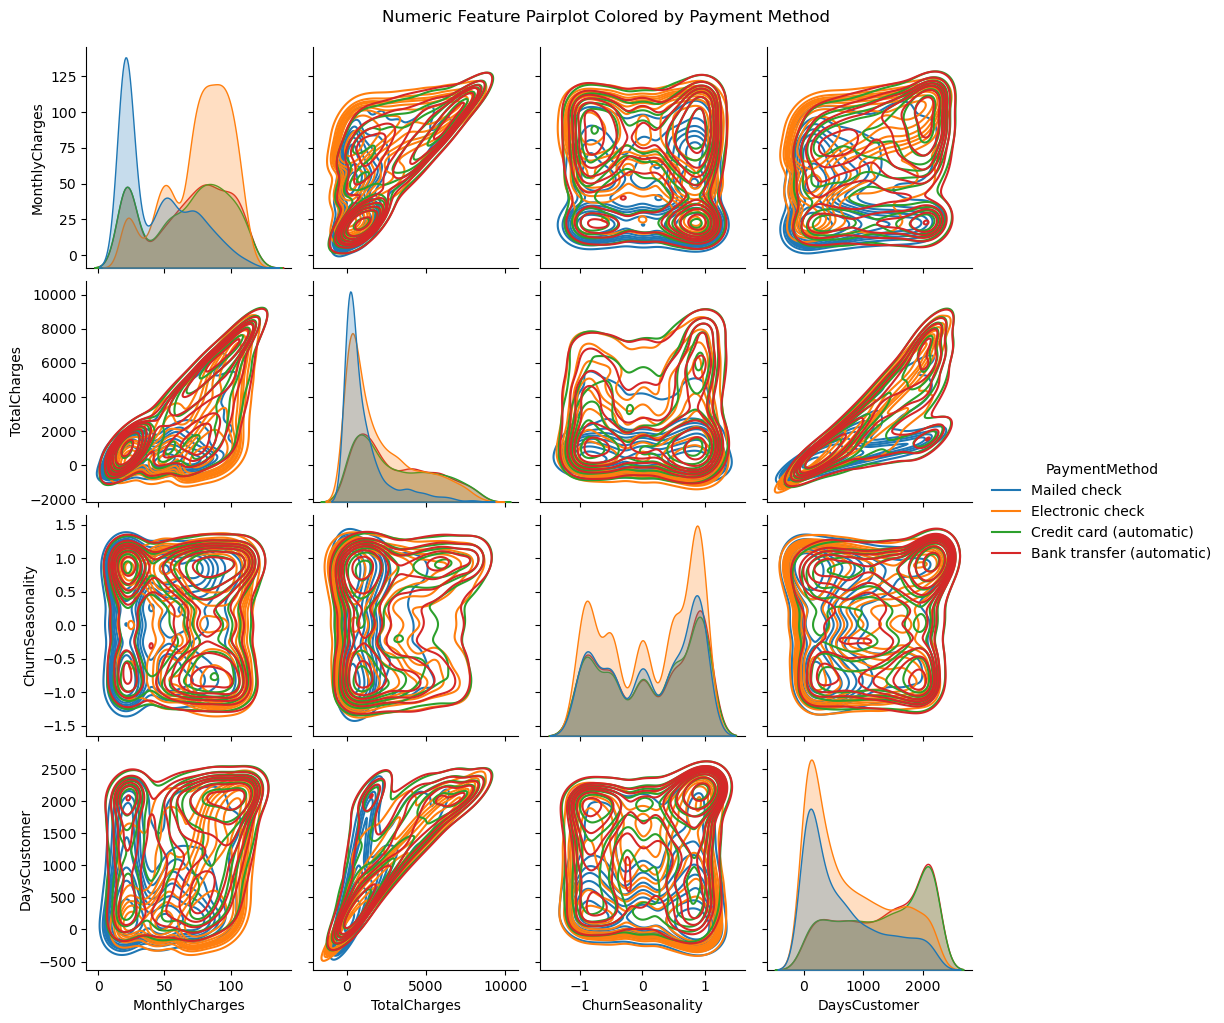

In [30]:
pp = sns.pairplot(df[['PaymentMethod'] + numeric_cols], kind='kde', hue='PaymentMethod')
pp.fig.suptitle("Numeric Feature Pairplot Colored by Payment Method", y=1.02)
plt.show()

The first graph gives us two obvious peaks: low monthly charges around the 25 dollar mark are dominated by mailed check delivery methods, and high monthly charges around the 90 dollar mark are dominated by electronic checks. Mailed check delivery has a significant right skew, and electronic checks have a significant left skew in the monthly charge graph. However, perhaps surprisingly, both of these methods dominate users who had low *total* charges (graph 5, or second row second graph) and thus low days as a customer (last graph, on the bottom right). Among the month-to-month users who dominate the low 'DaysCustomer' value range (demonstrated by the prior section of pairplot analysis) users are far more likely to use electronic checks or mailed checks.

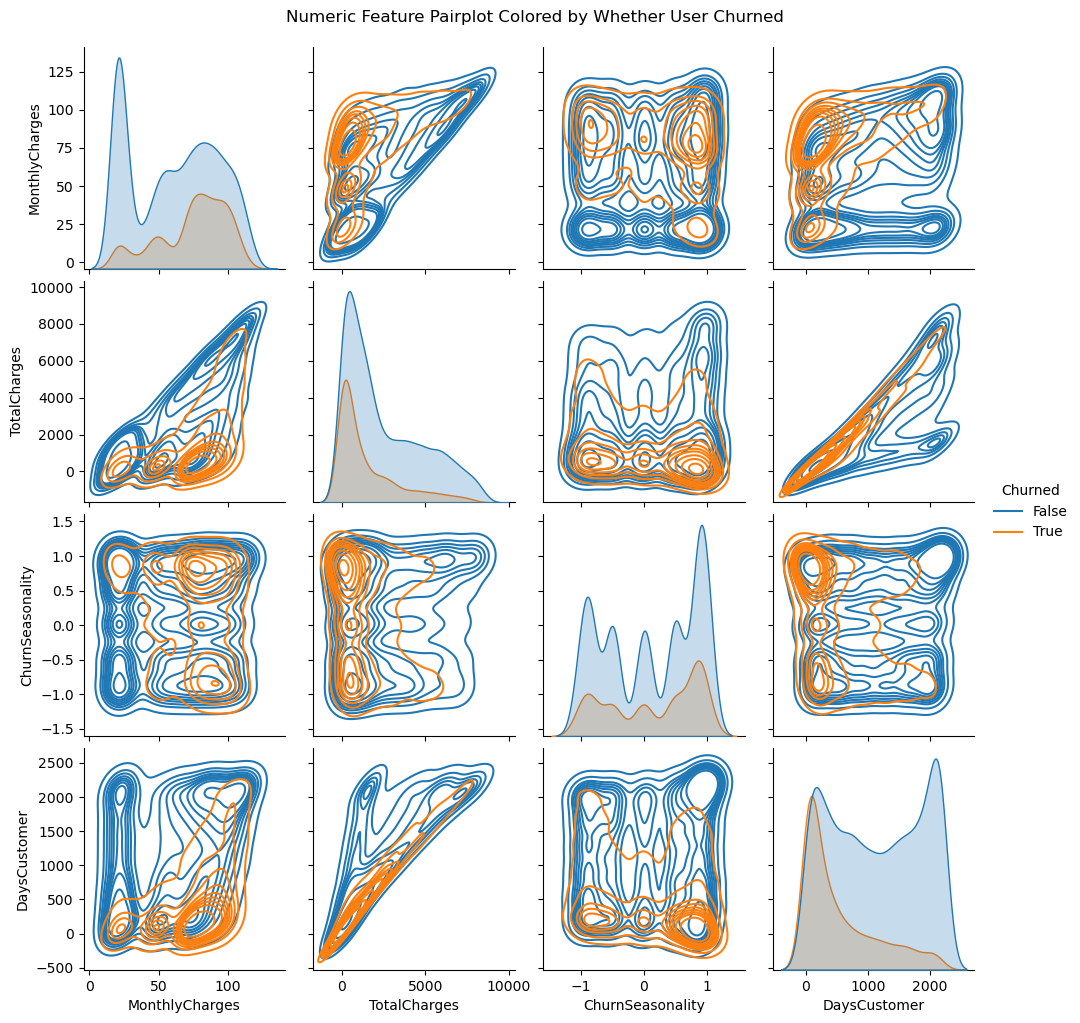

In [31]:
pp = sns.pairplot(df[['Churned'] + numeric_cols], kind='kde', hue='Churned')
pp.fig.suptitle("Numeric Feature Pairplot Colored by Whether User Churned", y=1.02)
plt.show()

The beauty of the KDE distribution plots are perceiving the hotspots. Given that the distribution of the 'DaysCustomer' indicates a severe right skew of users who churned, we can safely conclude that the target user at risk of churning has not been a customer for terribly long. However, looking at the sixteenth graph, users who have been customers for less than a single year are almost equally likely to churn versus not. We need more information to delineate user churn risk.

Looking at the eighth graph (last graph on the second row), it is clear that as users who are likely to churn continue to rack up InterConnect charges, those charges tend to be of high values, creating a very linear relationship between 'DaysCustomer' and 'TotalCharges.' Look at the very first graph -- there are peaks at high monthly charges (around 80 dollars) for both users who churn and who don't churn. However, there is a significant peak for users who didn't churn at about the 25 dollar mark that is barely present for users who did churn. The conclusion here is that users who churn tend to pay much higher monthly charges all the way until they churn. Based on the fourth graph, if a user has been a customer for longer than about two years, the only users who churn are those with high monthly charges.

### Examine Categorical Feature Distributions Against Target Feature

In [32]:
# We'll plot the categorical variables now.
cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Churned', 'gender', \
            'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', \
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', \
            'MultipleLines', 'HasInternet', 'HasPhone']
df['NotChurned'] = df['Churned'] == False

def label_axes(ax, i, feature):
    ax.set_title((f"{i+1}. {feature}"))
    ax.set_ylabel('# Users')
    ax.set_xlabel('')
    if feature=='PaymentMethod':
        xlabels = ['Bank', 'Credit', 'ECheck', 'Mail']
    else:
        xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, rotation=0)
    ax.get_legend().remove()
    
def add_counts(ax, data):
    for rownum in range(0, len(data)):
        ax.text(rownum, data.iloc[rownum]['NotChurned'], f"{data.iloc[rownum]['NotChurned']}", fontsize='small', ha='right')
        ax.text(rownum, data.iloc[rownum]['Churned'], f"{data.iloc[rownum]['Churned']}", fontsize='small', ha='left')

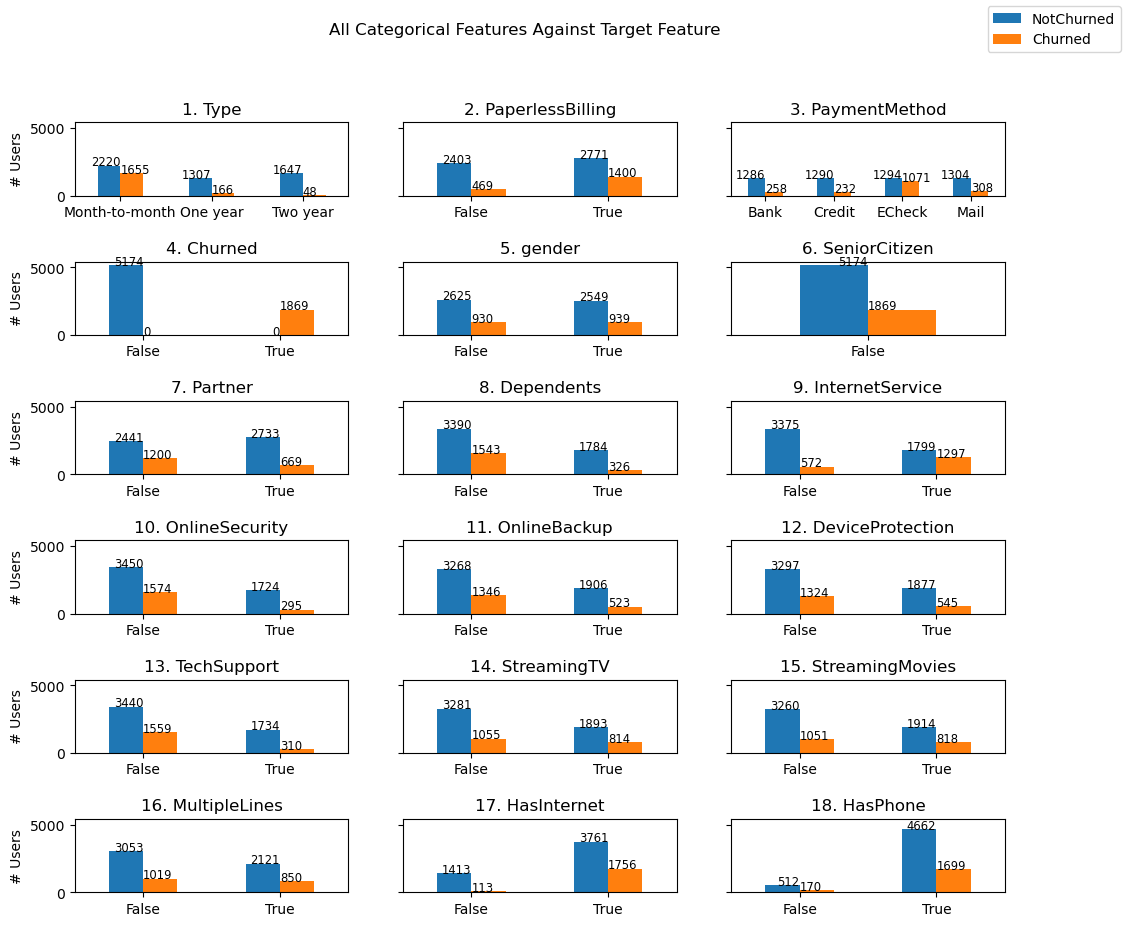

In [33]:
fig, axes = plt.subplots(6, 3, figsize=(12, 10), sharey=True, squeeze=False)

i = -1
for r in range(0, 6):
    for c in range(0, 3):
        i += 1
        feature = cat_cols[i]
        plotsum = df.groupby(feature)[['NotChurned', 'Churned']].sum()
        plotsum.plot(
            kind='bar', ax=axes[r, c]
        )
        label_axes(axes[r, c], i, feature)
        add_counts(axes[r, c], plotsum) 
plt.suptitle('All Categorical Features Against Target Feature')
fig.legend(['NotChurned', 'Churned'])
plt.subplots_adjust(hspace=0.9)
plt.show()

Laying out these features in such a brutalist, straightforward way allows us to make clear and obvious statements about how these categorical features interact with our target feature 'Churned'. 

Our fourth graph shows our class imbalance in our target feature of about 5:2. We should therefore treat upsampling, downsampling, or weighting classes as potential solutions to improve model performance if our model struggles.

Our first graph shows a clear demonstration of what has caused the right skew of month-to-month users in 'DaysCustomer': the users churn. Almost all churning users are on a month-to-month contract.

In the quantitative analysis section we found that ECheck and Mailed Check users tended to not be customers for long, with the former having high monthly charges and the latter having lower monthly charges. We also have a split in our target feature here: users who churned are over three times more likely to use Echecks than Mailed Checks.

The 'SeniorCitizen' feature contains False values for all users so it can be dropped.

Very starkly, users who did not appear on the df_internet dataframe (graph 17) were 14 times more likely not to churn.

Churning users were also:
- Three times more likely to use paperless billing (graph 2)
- Four times more likely to have no dependents (graph 8)
- Five times more likely not to use online security (graph 10)
- Five times more likely not to use technical support (graph 13)

In [34]:
# Our final lines of code will be to drop the 'SeniorCitizen' feature and save the dataframe in case of review
df = df.drop('SeniorCitizen', axis=1)
df.to_csv("./datasets/preprocessed_output.csv")

## Conclusions

The profile of a typical user who churns is one who has higher monthly charges, racks them up via ECheck charges without signing onto a one- or two-year plan, and then churns within the first two years of service. They did not use technical support, electronic billing, or most of the internet service options. They have no kids and tend to be without a partner.

### Questions

Clarifying questions for the upcoming training of the model include:

- Should we address the target feature class imbalance of 5:2?
- Are there any categorical features that can be encoded to reflect a somewhat quantitative number? We could encode the contract feature, for example to be 0, 1, and 2 to reflect month-to-month, one-year, and two-year contracts. However, since one-year and two-year contract data is very similar, and given a value of 0 is significant in model internal algorithms, it may make more sense to encode them as something like 1, 5, and 7.
- The model selection should be robust enough to make powerful predictions but lean enough for ipynb kernels. We can afford to use GridSearch to tune the hyperparameters, but does this data merit more processing power outside of the notebook?
- What degree and manner of gradient boosting should be executed? We have not previously gradient boosted on classification tasks, so some experimentation could be required, but some research suggests that given the number of boolean features we have, gradient boosting could be required to optimize the model.

### Next Steps

- **PREP DATA** | We will still have to do some prepping of data before moving into the land of modelling. We will want to encode categorical features, change all quantitative features to lie in the range of 0 to 1, and then split the data into training, validation, and test sets (since we will be tuning hyperparameters).

- **TRAIN MODELS** | We will train classification models with a grid search pipeline with f1_score as the target evaluation metric. We will try various models including RandomForestClassifier and some KNN-based cluster algorithms.

- **ANALYZE MODELS** | Our goal for the task is to achieve the best AUC-ROC score for our model. We will therefore chart the best-performing models and analyze some sample inputs and predictions to understand their strengths and weaknesses.

- **TUNE MODELS** | We will attempt various tuning methods on our best models and finally arrive at our ideal model. Tuning may consist of gradient boosting, class weight/imbalance fixes, and changes to encoding methods.

- **CONCLUSIONS AND BEST MODEL** | The best model from the last step will be measured and submitted as the final model, and we will make some conclusions based on what we have observed.

# Part 2: Model Training

We are looking at user service and demographic data and hoping to be able to predict which users will churn (discontinue service). Churn tasks are classic among machine learning tasks because most every company will want to know which of their users or clients are at risk of leaving, so they may be targeted with coupons and promotional services to prevent churn.

Below we will first perform our final preparation of the data, splitting it into two dataframes -- one with encoding for decision tree based classification models, and one with encoding for gradient boosting models that prefer ordinal encoding. Then we will train our models via a cross validation grid search to arrive at the optimal hyperparameters for this dataset, and evaluate their performances.

**As a reminder from the EDA section, our target feature is whether a given user churned, which was True when the 'EndDate' column value was equal to anything but 'No'. We no longer have the 'EndDate' feature but rather have our target feature 'Churned'.**

## Dataframe

In [35]:
# Quick reminder of current status of df
df.info()
display(df.sample(10, random_state=12345))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   bool   
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   Churned           7043 non-null   bool   
 7   DaysCustomer      7043 non-null   int64  
 8   ChurnSeasonality  7043 non-null   float64
 9   gender            7043 non-null   bool   
 10  Partner           7043 non-null   bool   
 11  Dependents        7043 non-null   bool   
 12  InternetService   7043 non-null   bool   
 13  OnlineSecurity    7043 non-null   bool   
 14  OnlineBackup      7043 non-null   bool   
 15  DeviceProtection  7043 non-null   bool   
 16  TechSupport       7043 non-null   bool   


customerID            Type  PaperlessBilling              PaymentMethod  \
1128  1657-DYMBM        Two year             False    Credit card (automatic)   
2875  4097-YODCF        One year              True           Electronic check   
1783  2606-RMDHZ  Month-to-month              True    Credit card (automatic)   
3804  5349-IECLD  Month-to-month             False           Electronic check   
6087  8626-PTQGE        Two year              True  Bank transfer (automatic)   
2071  2982-IHMFT  Month-to-month              True               Mailed check   
2395  3423-HHXAO        One year              True               Mailed check   
4660  6578-KRMAW  Month-to-month              True    Credit card (automatic)   
372   0550-DCXLH  Month-to-month             False               Mailed check   
1143  1684-FLBGS  Month-to-month              True    Credit card (automatic)   

      MonthlyCharges  TotalCharges  Churned  DaysCustomer  ChurnSeasonality  \
1128           19.90       1110.05    False          1614         -0.872929   
2875          103.80       3470.80    False          1036          0.516665   
1783           30.50        208.70     True           184         -0.999720   
3804           94.95        178.10     True            61          0.498137   
6087           60.05       4176.70    False          2102          0.031174   
2071           74.45         74.45     True            31          0.861147   
2395           19.50        272.00    False           427          0.486908   
4660           93.40       2979.30    False           975         -0.485029   
372            73.35        931.55    False           396          0.863325   
1143           69.50       1652.10    False           702          0.882206   

      gender  ...  OnlineSecurity  OnlineBackup  DeviceProtection  \
1128   False  ...           False         False             False   
2875   False  ...            True          True             False   
1783   False  ...           False          True             False   
3804   False  ...           False         False              True   
6087   False  ...            True          True             False   
2071    True  ...           False         False             False   
2395    True  ...           False         False             False   
4660   False  ...            True          True              True   
372    False  ...           False          True             False   
1143    True  ...           False          True             False   

      TechSupport  StreamingTV  StreamingMovies  MultipleLines  HasInternet  \
1128        False        False            False          False        False   
2875        False         True             True           True         True   
1783        False        False            False          False         True   
3804        False         True             True          False         True   
6087         True         True             True          False         True   
2071        False        False            False           True         True   
2395        False        False            False          False        False   
4660        False        False             True          False         True   
372          True         True             True          False         True   
1143         True         True            False           True         True   

      HasPhone  NotChurned  
1128      True        True  
2875      True        True  
1783     False       False  
3804      True       False  
6087     False        True  
2071      True       False  
2395      True        True  
4660      True        True  
372       True        True  
1143      True        True  

[10 rows x 23 columns]

## Final Preprocessing and Feature Split
You can see from the above table that we have some cleaning and encoding to do now that we are to feed the dataframe into some classification models. We also need to split the data into training, validation, and test sets, and scale numeric features. To make sure numeric and categorical features work best across every model without rescaling or reprocessing the dataframe, we will aim for values centered around 0 between -1 and 1 for ALL features.

Let's look at a sample of the non-boolean features:

In [36]:
display(df[['customerID', 'Type', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'DaysCustomer', 'ChurnSeasonality']].sample(10, random_state=12345))

customerID            Type              PaymentMethod  MonthlyCharges  \
1128  1657-DYMBM        Two year    Credit card (automatic)           19.90   
2875  4097-YODCF        One year           Electronic check          103.80   
1783  2606-RMDHZ  Month-to-month    Credit card (automatic)           30.50   
3804  5349-IECLD  Month-to-month           Electronic check           94.95   
6087  8626-PTQGE        Two year  Bank transfer (automatic)           60.05   
2071  2982-IHMFT  Month-to-month               Mailed check           74.45   
2395  3423-HHXAO        One year               Mailed check           19.50   
4660  6578-KRMAW  Month-to-month    Credit card (automatic)           93.40   
372   0550-DCXLH  Month-to-month               Mailed check           73.35   
1143  1684-FLBGS  Month-to-month    Credit card (automatic)           69.50   

      TotalCharges  DaysCustomer  ChurnSeasonality  
1128       1110.05          1614         -0.872929  
2875       3470.80          1036          0.516665  
1783        208.70           184         -0.999720  
3804        178.10            61          0.498137  
6087       4176.70          2102          0.031174  
2071         74.45            31          0.861147  
2395        272.00           427          0.486908  
4660       2979.30           975         -0.485029  
372         931.55           396          0.863325  
1143       1652.10           702          0.882206

### Cleaning and encoding
In the EDA section, we observed that when it came to contract type, user behavior deviated the most when users were on a month-to-month contract. It is also inherently short term, while one year and two year contracts are almost a category of contract of their own. When encoding these types to numeric values, it would not make sense to use an arithmetic or ordinal series such as 1, 2, and 3. We have an opportunity to make the encoded numbers reflect how similar one year and two year contracts are, and separate month-to-month values. Engineering the feature in this manner attempts to pass these relationships into the model, and aims to enhance performance over one-hot encoding.

But first, we can drop the customerID column as it is irrelevent to model training. We can also drop the 'NotChurned' column as it was used purely for EDA purposes, and more importantly as it is the inverse of our target feature, we CANNOT let it pass into models.

We will create two different dataframes -- one that is one-hot encoded or custom encoded for classic models, and one that preserves ordinally-split categories for our gradient boosting model.

In [37]:
# Drop customerID col
df = df.drop(['customerID', 'NotChurned'], axis=1)

# Make copy for the sake of the gradient boosting model
df_gbm = df.copy()

#### The 'Type' Column

In [38]:
# Encode 'Type' column to between -1 and 1
type_to_numeric = {
    'Month-to-month' : -1,
    'One year' : .5, 
    'Two year' : 1
}

df.replace({'Type': type_to_numeric}, inplace=True)
df['Type'] = df['Type'].astype('float64')

# Ordinally encode 'Type' column
type_to_ordinal = {
    'Month-to-month' : 1,
    'One year' : 2, 
    'Two year' : 3
}
df_gbm.replace({'Type': type_to_ordinal}, inplace=True)
df_gbm['Type'] = df_gbm['Type'].astype('int64')

C:\Users\brian\AppData\Local\Temp\ipykernel_19736\1703678482.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Type': type_to_numeric}, inplace=True)
C:\Users\brian\AppData\Local\Temp\ipykernel_19736\1703678482.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_gbm.replace({'Type': type_to_ordinal}, inplace=True)


#### The 'PaymentMethod' Column

In [39]:
# One-Hot Encode (OHE) 'PaymentMethod' column
df_ohe = pd.get_dummies(df['PaymentMethod'])
display(df_ohe.sample(10, random_state=12345))
df = df.drop('PaymentMethod', axis=1)
df = pd.concat([df, df_ohe], axis=1)

# Ordinally encode 'PaymentMethod' column
payment_to_ordinal = {
    'Bank transfer (automatic)' : 1,
    'Credit card (automatic)' : 2, 
    'Electronic check' : 3,
    'Mailed check' : 4
}
df_gbm.replace({'PaymentMethod': payment_to_ordinal}, inplace=True)
df_gbm['PaymentMethod'] = df_gbm['PaymentMethod'].astype('int64')

Bank transfer (automatic)  Credit card (automatic)  Electronic check  \
1128                      False                     True             False   
2875                      False                    False              True   
1783                      False                     True             False   
3804                      False                    False              True   
6087                       True                    False             False   
2071                      False                    False             False   
2395                      False                    False             False   
4660                      False                     True             False   
372                       False                    False             False   
1143                      False                     True             False   

      Mailed check  
1128         False  
2875         False  
1783         False  
3804         False  
6087         False  
2071          True  
2395          True  
4660         False  
372           True  
1143         False

C:\Users\brian\AppData\Local\Temp\ipykernel_19736\401535105.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_gbm.replace({'PaymentMethod': payment_to_ordinal}, inplace=True)


In [40]:
# Check our work before scaling
display(df.sample(10, random_state=12345))

Type  PaperlessBilling  MonthlyCharges  TotalCharges  Churned  \
1128   1.0             False           19.90       1110.05    False   
2875   0.5              True          103.80       3470.80    False   
1783  -1.0              True           30.50        208.70     True   
3804  -1.0             False           94.95        178.10     True   
6087   1.0              True           60.05       4176.70    False   
2071  -1.0              True           74.45         74.45     True   
2395   0.5              True           19.50        272.00    False   
4660  -1.0              True           93.40       2979.30    False   
372   -1.0             False           73.35        931.55    False   
1143  -1.0              True           69.50       1652.10    False   

      DaysCustomer  ChurnSeasonality  gender  Partner  Dependents  ...  \
1128          1614         -0.872929   False     True       False  ...   
2875          1036          0.516665   False    False        True  ...   
1783           184         -0.999720   False    False       False  ...   
3804            61          0.498137   False    False       False  ...   
6087          2102          0.031174   False    False       False  ...   
2071            31          0.861147    True    False       False  ...   
2395           427          0.486908    True     True        True  ...   
4660           975         -0.485029   False    False       False  ...   
372            396          0.863325   False    False       False  ...   
1143           702          0.882206    True     True        True  ...   

      TechSupport  StreamingTV  StreamingMovies  MultipleLines  HasInternet  \
1128        False        False            False          False        False   
2875        False         True             True           True         True   
1783        False        False            False          False         True   
3804        False         True             True          False         True   
6087         True         True             True          False         True   
2071        False        False            False           True         True   
2395        False        False            False          False        False   
4660        False        False             True          False         True   
372          True         True             True          False         True   
1143         True         True            False           True         True   

      HasPhone  Bank transfer (automatic)  Credit card (automatic)  \
1128      True                      False                     True   
2875      True                      False                    False   
1783     False                      False                     True   
3804      True                      False                    False   
6087     False                       True                    False   
2071      True                      False                    False   
2395      True                      False                    False   
4660      True                      False                     True   
372       True                      False                    False   
1143      True                      False                     True   

      Electronic check  Mailed check  
1128             False         False  
2875              True         False  
1783             False         False  
3804              True         False  
6087             False         False  
2071             False          True  
2395             False          True  
4660             False         False  
372              False          True  
1143             False         False  

[10 rows x 24 columns]

### Splitting and Scaling Data
We will split the data on a 3:1:1 ratio for training, validation, and testing. We have 7,043 total rows, so we are looking at using a training set of about 4,226 rows.

In [41]:
# Separate dataframes into features and targets and randomize using train_test_split
features = df.drop(['Churned'], axis=1)
target = df['Churned']

features_gbm = df_gbm.drop(['Churned'], axis=1)
target_gbm = df_gbm['Churned']

# Split data to make train and test sets in ratio of 4:1 (KFold will further divide training set into validation set)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)
features_gbm_train, features_gbm_test, target_gbm_train, target_gbm_test = train_test_split(features_gbm, target_gbm, test_size=0.2, random_state=12345)

The 'MonthlyCharges', 'TotalCharges', and 'DaysCustomer' features do not appear have outliers or exceptional distributions which might merit specialty rescaling techniques (see EDA). Therefore, we will use a simple scaling technique to place all three of these features in approximately the -1 to 1 range with a mean of 0 and unit distribution of 0. Models perform best with similarly-scaled feature ranges.

'ChurnSeasonality' is an engineered feature that attempts to capture what time of year users churn service. While its mean is not 0 (see EDA), its distribution is already between -1 and 1, and rescaling the feature would change the underlying sinusoidal seasonality. We will leave this feature as-is.

In [42]:
# Scale numeric to approx. between -1 and 1, mean and unit distr. = 0
scale_features = ['MonthlyCharges', 'TotalCharges', 'DaysCustomer']

# Standardizing each feature's scaling is very important when features differ by any order of magnitude
ss = StandardScaler()
ss.fit(features_train[scale_features])
features_train[scale_features] = ss.transform(features_train[scale_features])
features_test[scale_features] = ss.transform(features_test[scale_features])
features_gbm_train[scale_features] = ss.transform(features_train[scale_features])
features_gbm_test[scale_features] = ss.transform(features_test[scale_features])

In [43]:
# Check our work
display(df.sample(10, random_state=12345))
display(df_gbm.sample(10, random_state=12345))

Type  PaperlessBilling  MonthlyCharges  TotalCharges  Churned  \
1128   1.0             False           19.90       1110.05    False   
2875   0.5              True          103.80       3470.80    False   
1783  -1.0              True           30.50        208.70     True   
3804  -1.0             False           94.95        178.10     True   
6087   1.0              True           60.05       4176.70    False   
2071  -1.0              True           74.45         74.45     True   
2395   0.5              True           19.50        272.00    False   
4660  -1.0              True           93.40       2979.30    False   
372   -1.0             False           73.35        931.55    False   
1143  -1.0              True           69.50       1652.10    False   

      DaysCustomer  ChurnSeasonality  gender  Partner  Dependents  ...  \
1128          1614         -0.872929   False     True       False  ...   
2875          1036          0.516665   False    False        True  ...   
1783           184         -0.999720   False    False       False  ...   
3804            61          0.498137   False    False       False  ...   
6087          2102          0.031174   False    False       False  ...   
2071            31          0.861147    True    False       False  ...   
2395           427          0.486908    True     True        True  ...   
4660           975         -0.485029   False    False       False  ...   
372            396          0.863325   False    False       False  ...   
1143           702          0.882206    True     True        True  ...   

      TechSupport  StreamingTV  StreamingMovies  MultipleLines  HasInternet  \
1128        False        False            False          False        False   
2875        False         True             True           True         True   
1783        False        False            False          False         True   
3804        False         True             True          False         True   
6087         True         True             True          False         True   
2071        False        False            False           True         True   
2395        False        False            False          False        False   
4660        False        False             True          False         True   
372          True         True             True          False         True   
1143         True         True            False           True         True   

      HasPhone  Bank transfer (automatic)  Credit card (automatic)  \
1128      True                      False                     True   
2875      True                      False                    False   
1783     False                      False                     True   
3804      True                      False                    False   
6087     False                       True                    False   
2071      True                      False                    False   
2395      True                      False                    False   
4660      True                      False                     True   
372       True                      False                    False   
1143      True                      False                     True   

      Electronic check  Mailed check  
1128             False         False  
2875              True         False  
1783             False         False  
3804              True         False  
6087             False         False  
2071             False          True  
2395             False          True  
4660             False         False  
372              False          True  
1143             False         False  

[10 rows x 24 columns]

Type  PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  \
1128     3             False              2           19.90       1110.05   
2875     2              True              3          103.80       3470.80   
1783     1              True              2           30.50        208.70   
3804     1             False              3           94.95        178.10   
6087     3              True              1           60.05       4176.70   
2071     1              True              4           74.45         74.45   
2395     2              True              4           19.50        272.00   
4660     1              True              2           93.40       2979.30   
372      1             False              4           73.35        931.55   
1143     1              True              2           69.50       1652.10   

      Churned  DaysCustomer  ChurnSeasonality  gender  Partner  ...  \
1128    False          1614         -0.872929   False     True  ...   
2875    False          1036          0.516665   False    False  ...   
1783     True           184         -0.999720   False    False  ...   
3804     True            61          0.498137   False    False  ...   
6087    False          2102          0.031174   False    False  ...   
2071     True            31          0.861147    True    False  ...   
2395    False           427          0.486908    True     True  ...   
4660    False           975         -0.485029   False    False  ...   
372     False           396          0.863325   False    False  ...   
1143    False           702          0.882206    True     True  ...   

      InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
1128            False           False         False             False   
2875             True            True          True             False   
1783            False           False          True             False   
3804             True           False         False              True   
6087            False            True          True             False   
2071             True           False         False             False   
2395            False           False         False             False   
4660             True            True          True              True   
372             False           False          True             False   
1143            False           False          True             False   

      TechSupport  StreamingTV  StreamingMovies  MultipleLines  HasInternet  \
1128        False        False            False          False        False   
2875        False         True             True           True         True   
1783        False        False            False          False         True   
3804        False         True             True          False         True   
6087         True         True             True          False         True   
2071        False        False            False           True         True   
2395        False        False            False          False        False   
4660        False        False             True          False         True   
372          True         True             True          False         True   
1143         True         True            False           True         True   

      HasPhone  
1128      True  
2875      True  
1783     False  
3804      True  
6087     False  
2071      True  
2395      True  
4660      True  
372       True  
1143      True  

[10 rows x 21 columns]

Our dataframe is finalized and ripe for passing into models.

## Model Training

We will be training two classification models before diving into a classic gradient boosting model, LightGBMClassifier(). For all models we will set up a KFold cross-validation and use a grid pipeline to optimize hyperparameters based on f1-score.

### Initializing Helper Functions

The below definition is a helper function for any classification model with .fit() and .predict() methods. It can return a dictionary of evaluation metrics, as well as the trained model if return_model is set to False.

In [44]:
def eval_model(model_name, model, X, y, Xtest, ytest, fit_params={}, return_model=False, verbose=0):
    '''
    This function takes as parameters the kind of model being used (str), an untrained model object, 
    training data (X and target y), and test data.
    
    It returns a dataframe that can be used later to concatenate with other evaluation dataframes.
    '''   
    
    # Train model predictions
    model.fit(X, y, **fit_params)
    
    # Make model predictions
    predictions = model.predict(Xtest)
    
    # Create return data
    return_dict = {
        'model_name':     model_name,                                       # Model Name
        'AUC-ROC' :       roc_auc_score(ytest, predictions),                # ROC Area Under Curve Score
        'precision' :     precision_score(ytest, predictions),              # Precision score (how many)
        'recall' :        recall_score(ytest, predictions),                 # Recall score (how many)
    }

    if verbose > 0:
        display(return_dict)
    if return_model:
        return (return_dict, model)
    else:
        return return_dict

In [45]:
'''
SCRIPTING PARAMETERS -- PLEASE READ

Grid searches take a very long time to compute over hyperparameters. 

The below boolean variables toggle the execution of time-consuming model training and the saving and loading of model data.

!!!
If you are running the script without saving or loading, please set both values below to False.
!!!

''' 
# If the below is True, then variables necessary for model evaluation will be saved, REGARDLESS of whether they were loaded or not.
save_it = True

# If the below is True, then saved JSON and PICKLE objects will be loaded. If False, grid searches are executed.
load_override = False

All preamble is finished, and we are ready to train and evaluate models.

For each model we will allow a grid search function to tune hyperparameters, optimizing on f1_score. We will ensure the grid search tunes hyperparameters using a validation set separate from training sets. This is accomplished via KFold() cross validation.

### DecisionTreeClassifier

In [46]:
# Initialize model, cross validation, grid search pipeline
parameter_grid = {
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['log_loss', 'gini', 'entropy'],
    'max_depth': [4, 6, 8, 12, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 6, 10]
}
tree = DecisionTreeClassifier(
    random_state=12345, class_weight='balanced'
)
cross_validator = KFold(
    n_splits=4, shuffle=True, random_state=12345
)
tree_GSCV = GridSearchCV(
    estimator=tree, param_grid=parameter_grid, scoring = 'f1', cv = cross_validator, verbose=3
)

In [47]:
# Run training -- This could take a long time!
if not load_override:
    tree_GSCV.fit(features_train, target_train)

Fitting 4 folds for each of 540 candidates, totalling 2160 fits
[CV 1/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.579 total time=   0.0s
[CV 2/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.592 total time=   0.0s
[CV 3/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.586 total time=   0.0s
[CV 4/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.600 total time=   0.0s
[CV 1/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;, score=0.579 total time=   0.0s
[CV 2/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;, score=0.592 total time=   0.0s
[CV 3/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;

In [48]:
# I/0 locations
tree_model_pickle = './datasets/model_data/best_tree.pickle'
tree_stats_json = './datasets/model_data/best_tree_stats.json'

# If new execution of grid search, get stats and best performing model. Otherwise, use load_override to load them from previous execution
if load_override:
    with open(tree_model_pickle, 'rb') as handle:
        best_tree_model = pickle.load(handle)
    with open(tree_stats_json, 'r') as file:
        tree_stats = json.load(file)
else:
    print(tree_GSCV.best_params_)
    print(tree_GSCV.best_score_)

    model=DecisionTreeClassifier(
        random_state=12345, class_weight='balanced', **tree_GSCV.best_params_
    )
    tree_stats, best_tree_model = eval_model('Decision Tree', model, features_train, target_train, features_test, target_test, return_model=True, verbose=1)

# Save 
if save_it:
    with open(tree_model_pickle, 'wb') as handle:
        pickle.dump(best_tree_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(tree_stats_json, 'w') as file:
        json.dump(tree_stats, file, indent=4)

{'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.6452445637202004


{'model_name': 'Decision Tree',
 'AUC-ROC': 0.7821456943120432,
 'precision': 0.5319926873857403,
 'recall': 0.8083333333333333}

### RandomForestClassifier

In [49]:
# Initialize model, cross validation, grid search pipeline
parameter_grid = {
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [25, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [6, 12, None],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6]
}
forest = RandomForestClassifier(
    random_state=12345, n_jobs = -1, class_weight='balanced'
)
cross_validator = KFold(
    n_splits=4, shuffle=True, random_state=12345
)
forest_GSCV = GridSearchCV(
    estimator=forest, param_grid=parameter_grid, scoring = 'f1', cv = cross_validator, verbose=3
)

In [50]:
# Run training -- This could take a long time!
if not load_override:
    forest_GSCV.fit(features_train, target_train)

Fitting 4 folds for each of 648 candidates, totalling 2592 fits
[CV 1/4] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.643 total time=   0.0s
[CV 2/4] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.659 total time=   0.0s
[CV 3/4] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.639 total time=   0.0s
[CV 4/4] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.652 total time=   0.0s
[CV 1/4] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.641 total time=   0.0s
[CV 2/4] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.648 total time=   0.0s
[CV 3/4] END criterion=gini, m

In [51]:
# I/0 locations
forest_model_pickle = './datasets/model_data/best_forest.pickle'
forest_stats_json = './datasets/model_data/best_forest_stats.json'

# If new execution of grid search, get stats and best performing model. Otherwise, use load_override to load them from previous execution
if load_override:
    with open(forest_model_pickle, 'rb') as handle:
        best_forest_model = pickle.load(handle)
    with open(forest_stats_json, 'w') as file:
        forest_stats = json.load(file)
else:
    print(forest_GSCV.best_params_)
    print(forest_GSCV.best_score_)

    model=RandomForestClassifier(
        random_state=12345, class_weight='balanced', n_jobs=-1, **forest_GSCV.best_params_
    )
    forest_stats, best_forest_model = eval_model('Random Forest', model, features_train, target_train, features_test, target_test, return_model=True, verbose=1)

# Save 
if save_it:
    with open(forest_model_pickle, 'wb') as handle:
        pickle.dump(best_forest_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(forest_stats_json, 'w') as file:
        json.dump(forest_stats, file, indent=4)

{'criterion': 'entropy', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.6856830746593039


{'model_name': 'Random Forest',
 'AUC-ROC': 0.8093872471136532,
 'precision': 0.6785714285714286,
 'recall': 0.7388888888888889}

### Light GBM

In [52]:
parameter_grid = {
    'num_leaves': [15, 30, 60],
    'n_estimators': [200, 300],
    'max_depth': [5, 9, -1],
    'min_child_samples': [10, 20, 50], 
    'subsample': [0.8, 0.9 ],
    'learning_rate': [0.1, 0.05],
}
categorical_feature_indices = [features_gbm_train.columns.get_loc(col) for col in ['Type', 'PaymentMethod']]
fit_params = {"categorical_feature": categorical_feature_indices}

# Initialize model, cross validation, grid search pipeline

lgbm = lgb.LGBMClassifier(
    random_state=12345, n_jobs = 4, class_weight='balanced', force_row_wise=True, verbosity=0
)
cross_validator = KFold(
    n_splits=4, shuffle=True, random_state=12345
)
gbm_GSCV = GridSearchCV(
    estimator=lgbm, param_grid=parameter_grid, scoring = 'f1', cv = cross_validator
)

In [53]:
# Run training -- This could take a long time!
if not load_override:
    gbm_GSCV.fit(features_gbm_train, target_gbm_train, **fit_params); # Adding semicolon here to ensure we suppress output to avoid file size creep

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [54]:
# I/0 locations
gbm_model_pickle = './datasets/model_data/best_gbm.pickle'
gbm_stats_json = './datasets/model_data/best_gbm_stats.json'

# If new execution of grid search, get stats and best performing model. Otherwise, use load_override to load them from previous execution
if load_override:
    with open(gbm_model_pickle, 'rb') as handle:
        best_gbm_model = pickle.load(handle)
    with open(gbm_stats_json, 'w') as file:
        gbm_stats = json.load(file)
else:
    print(gbm_GSCV.best_params_)
    print(gbm_GSCV.best_score_)

    model=lgb.LGBMClassifier(
        random_state=12345, class_weight='balanced', n_jobs=-1, **gbm_GSCV.best_params_
    )
    gbm_stats, best_gbm_model = eval_model('LightGBM', model, features_gbm_train, target_gbm_train, features_gbm_test, target_gbm_test, return_model=True, verbose=1)

# Save 
if save_it:
    with open(gbm_model_pickle, 'wb') as handle:
        pickle.dump(best_gbm_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(gbm_stats_json, 'w') as file:
        json.dump(gbm_stats, file, indent=4)

{'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 15, 'subsample': 0.8}
0.777806763347035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


{'model_name': 'LightGBM',
 'AUC-ROC': 0.8748702467958903,
 'precision': 0.7350835322195705,
 'recall': 0.8555555555555555}

### Cleanup

We can clear variables to conserve memory.

In [55]:
del tree_GSCV, forest_GSCV, gbm_GSCV, tree, forest, lgbm, cross_validator, parameter_grid

## Evaluate Models

We can accumulate the saved statistics from the above training and display how well each model did at predicting users who churned service:

In [56]:
# Concat all stats thus far
tree_stats_df = pd.DataFrame(tree_stats, index=[tree_stats['model_name']], columns=['AUC-ROC', 'precision', 'recall'])
forest_stats_df = pd.DataFrame(forest_stats, index=[forest_stats['model_name']], columns=['AUC-ROC', 'precision', 'recall'])
gbm_stats_df = pd.DataFrame(gbm_stats, index=[gbm_stats['model_name']], columns=['AUC-ROC', 'precision', 'recall'])
eval_df = pd.concat([tree_stats_df, forest_stats_df, gbm_stats_df])
display(eval_df)

AUC-ROC  precision    recall
Decision Tree  0.782146   0.531993  0.808333
Random Forest  0.809387   0.678571  0.738889
LightGBM       0.874870   0.735084  0.855556

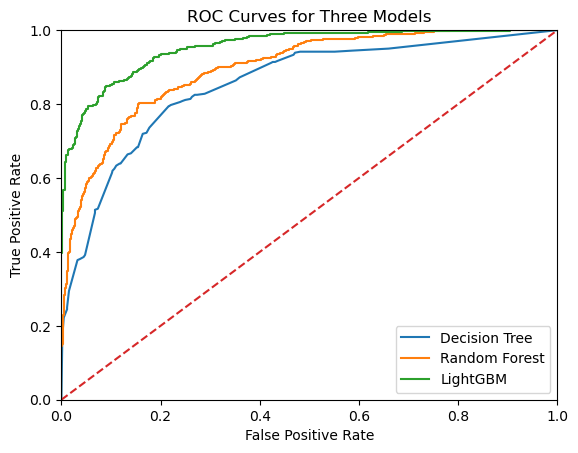

In [57]:
# Use best performing models for probability testing
# Plot ROC curve
probabilities_tree = best_tree_model.predict_proba(features_test)
predictions_tree = probabilities_tree[:, 1]
probabilities_forest = best_forest_model.predict_proba(features_test)
predictions_forest = probabilities_forest[:, 1]
probabilities_gbm = best_gbm_model.predict_proba(features_gbm_test)
predictions_gbm = probabilities_gbm[:, 1]
fpr1, tpr1, thresholds = roc_curve(target_test, predictions_tree)
fpr2, tpr2, thresholds = roc_curve(target_test, predictions_forest)
fpr3, tpr3, thresholds = roc_curve(target_gbm_test, predictions_gbm)
plt.figure()
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)

# Sanity check line (representing random guess model)
plt.plot([0, 1], [0, 1], linestyle='--')

# Cleaning and labeling
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Three Models')
plt.legend(eval_df.index)

plt.show()

## Conclusion

In this notebook we trained three models to predict user churn rate, with their demographic and service plan information as input features. We found that a gradient boosting model performed best over more classic decision tree modeling, with an AUC-ROC of .8766.

We may now address some of the concerns and matters brought up at the end of the EDA section. We handled class imbalance by setting the class_weight parameter for each model to 'balanced.' Our special encoding of the 'Type' feature to try to capture some trends we observed in the EDA did not elevate the decision tree models to especially high performance. The gradient boosting effect far better captured differences in classes. 

During this process we had to iterate down the LightGBMClassifier training multiple times to prevent memory overflow issues. We wanted to avoid alternative grid search methods (such as RandomizedSearchCV) to ensure we captured the best hyperparameters -- so we simply tried smaller hyperparameter sets and lowered the parallel jobs from -1 (i.e. max) to 4. This solved our memory issues.